In [1]:
%run PVModel_functions.ipynb

In [2]:
#This cell imports all the necessary packages & module data
import pandas as pd 
import numpy as np
from datetime import datetime
import datatools
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import pvlib
import pvanalytics
import math

%matplotlib inline 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

mpl.rcParams['font.size']=12
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=10
#mpl.rcParams['font.weight']='bold'
mpl.rcParams['axes.titlesize']=22

mod_info = pd.read_excel('module_coefficients.xlsx')
mod_info.index = mod_info['Manufacturer']
del mod_info['Manufacturer']


In [3]:
#This is where all the input info should be
module = mod_info['Panasonic']
mettablename =  'dbo.SNLA_Met_DataOut'
systablename =  'dbo.PVLT_Pan_LG_Panasonic_LG'

start = module['start']
end = module['end']

In [4]:
#Import sys & met databases & merge into one df
df = sys_met_data(mettablename, systablename, start, end)

In [5]:
#Calculate solpos & other environmental data, like airmass, aoi, and differnt poa components
sdf = calc_sol_data(df.index, module['latitude'], module['longitude'], module['tilt'], df['Pressure_mBar_Avg'])
edf = calc_env_data(module['tilt'], module ['altitude'], module['surface_azimuth'], sdf['azimuth'], sdf['apparent_zenith'], 
               df['Direct_Wm2_Avg'], df['Global_Wm2_Avg'], df['Diffuse_Wm2_Avg'], sdf['dni_extra'], model = 'haydavies')
edf['am_abs'] = pvlib.atmosphere.get_absolute_airmass(edf['airmass'], edf['pressure'])
sedf = pd.merge(edf,sdf,how='inner', left_index=True, right_index=True)

In [6]:
#Generate a results dataframe and add measured values
results = meas_val(df['PH4_V_Avg'],df['PH4_I_Avg'])
results = results.to_frame()

In [8]:
#Calcualte SAPM results and add to df
sapm_par = sapm_param(sedf['poa_global'], edf['poa_direct'], edf['poa_diffuse'], df.AmbientTemp_Avg, df.Wind_Speed_Avg, 
                   sedf['am_abs'], sedf['aoi'], module)
dc = sapm(sapm_par['eff_irr'], sapm_par['tcell'], module)
results['SAPM'] = sapm_p(dc['v_mp'], dc['i_mp'], module['str_len'])

In [10]:
#Calculate PVWatts results and add to df
results['PVWatts'] = pvwatts(POA_eff = df['BroadbandPOA_Avg'], cell_temp = df['PH2_RTD_Avg'], stc_mod_p = module['Power'], 
                             Gpmp = module['Gpmp'],str_len = module['str_len'], temp_ref=25.0 )

In [12]:
#Calculate CEC results and add to df
cec_param = pvlib.pvsystem.calcparams_cec( df['BroadbandPOA_Avg'], df['PH1_RTD_Avg'], module['alpha_sc'], module['a_ref'], 
                                             module['I_L_ref'], module['I_o_ref'], module['R_sh_ref'], module['R_s'], 
                                             module['Adjust'], module['Cells_in_Series'])
cec_p = pvlib.pvsystem.singlediode(photocurrent = cec_param[0], saturation_current = cec_param[1], resistance_series =
                           cec_param[2], resistance_shunt = cec_param[3], nNsVth = cec_param[4])
results['CEC'] = sdm(cec_p['p_mp'], module['str_len'])

In [13]:
ds_param = pvlib.pvsystem.calcparams_desoto(df['BroadbandPOA_Avg'], df['PH1_RTD_Avg'], module['alpha_sc'], module['a_ref'], 
                                        module['I_L_ref'], module['I_o_ref'], module['R_sh_ref'], module['R_s'])
ds_p = pvlib.pvsystem.singlediode(photocurrent = ds_param[0], saturation_current = ds_param[1], resistance_series =
                           ds_param[2], resistance_shunt = ds_param[3], nNsVth = ds_param[4])
results['Desoto'] = sdm(ds_p['p_mp'], module['str_len'])

In [16]:
pvs_param = pvlib.pvsystem.calcparams_pvsyst(df['BroadbandPOA_Avg'], df['PH1_RTD_Avg'], module['alpha_sc'], module['gamma_ref'],
                                            module['mu_gamma'], module['I_L_ref'], module['I_o_ref'], module['R_sh_ref'], module['R_sh_0'], 
                                            module['R_s'],  module['Cells_in_Series'])
pvs_p = pvlib.pvsystem.singlediode(photocurrent = pvs_param[0], saturation_current = pvs_param[1], resistance_series =
                           pvs_param[2], resistance_shunt = pvs_param[3], nNsVth = pvs_param[4])
results['PVSyst'] = sdm(pvs_p['p_mp'], module['str_len'])

Text(0, 0.5, 'Power (W)')

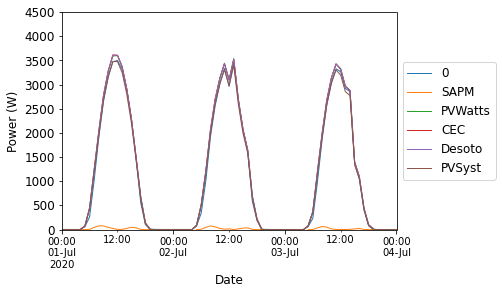

In [17]:
results.plot()
plt.xlim('2020-07-01', '2020-07-04')
plt.ylim(0,4500)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.xlabel('Date')
plt.ylabel('Power (W)')